In [2]:
import sys
import platform
import src.data.reader as rd
from pathlib import PurePath
from multiprocessing import cpu_count
from src.utils.utils import *

print('Python %s on %s' % (sys.version, sys.platform))

pdir = get_relative_project_dir('FinML', partial=False)
# for notebook references
sys.path.extend([pdir])
print(pdir)

data_dir = pdir / 'data'
data_raw_dir = data_dir / 'raw'
data_interim_dir = data_dir / 'interim'
data_processed_dir = data_dir / 'processed'
file_name = 'IVE_tickbidask'

Python 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] on darwin
/Users/scottblunsden/Programs/FinML


In [3]:
# Uncomment out to read from a raw data and save to a parquet file
# some code to download from internet goes here
#reader = rd.Reader()
#txt_file_name = file_name + '.txt'
#infp = PurePath(data_raw_dir / txt_file_name)
#df = reader.read_kibot_ticks(infp)

#parq_file_name = file_name+'.parq'
#outfp = PurePath(data_raw_dir / parq_file_name)

# Save file to parquet
#df.to_parquet(outfp)


In [4]:
# Load from parquet
parq_file_name = file_name + '.parq'
infp = PurePath(data_raw_dir / parq_file_name)
df = pd.read_parquet(infp)


/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [5]:
import src.features.datacleaner as dc

data_cleaner = dc.DataCleaner()

df = data_cleaner.remove_outliers(df, 'price')
df = df.resample('1T').median().drop_duplicates().dropna()

In [6]:
import src.features.bars as bar
import src.features.labeller as lab

bars = bar.Bars()
dbars = bars.dollar_bar_df(df, 'dv', 10_000).drop_duplicates().dropna()

close = dbars.price.copy()
labeller = lab.Labeller()
dailyVol = labeller.getDailyVol(close).dropna()


  0%|          | 0/565466 [00:00<?, ?it/s]

 22%|██▏       | 121653/565466 [00:00<00:00, 1216516.66it/s]

 44%|████▍     | 250459/565466 [00:00<00:00, 1237127.97it/s]

 67%|██████▋   | 380988/565466 [00:00<00:00, 1256816.69it/s]

 93%|█████████▎| 524142/565466 [00:00<00:00, 1304582.06it/s]

100%|██████████| 565466/565466 [00:00<00:00, 1326690.36it/s]

In [7]:
import src.features.indicators.crossover as cross
crossover = cross.MACrossover()

fast_window = 3
slow_window = 7


side = crossover.get_side(close, fast_window, slow_window)


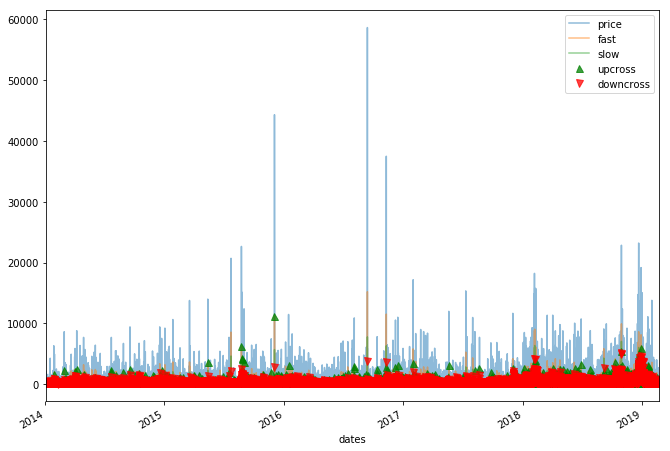

In [8]:
import matplotlib.pyplot as plt

close_df = crossover.close_df(close, fast_window, slow_window)
up = crossover.get_up_cross(close_df)
down = crossover.get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

In [9]:
tEvents = labeller.getTEvents(close_df['price'], h=dailyVol.mean())
t1 = labeller.addVerticalBarrier(tEvents, close_df['price'], numDays=1)

target = dailyVol

# Run in single-threaded mode on Windows

if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1

minRet = .01 
ptsl=[1, 2]

ma_events = labeller.getEvents(close_df['price'], tEvents, ptsl, target, minRet, cpus, t1=t1, side=side)

ma_side = ma_events.dropna().side
ma_bins = labeller.getBinsNew(ma_events, close_df['price'], t1).dropna()

Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')

data_processed_dir = data_dir / 'processed'
parq_file_name = file_name + '_crossover_train_test.parq'

outfp = PurePath(data_processed_dir / parq_file_name)

Xx.to_parquet(outfp)



  0%|          | 0/521229 [00:00<?, ?it/s]

  0%|          | 275/521229 [00:00<03:09, 2749.56it/s]

  0%|          | 914/521229 [00:00<02:36, 3315.75it/s]

  0%|          | 1619/521229 [00:00<02:11, 3941.93it/s]

  0%|          | 2292/521229 [00:00<01:55, 4500.90it/s]

  1%|          | 3058/521229 [00:00<01:40, 5136.33it/s]

  1%|          | 3800/521229 [00:00<01:31, 5658.15it/s]

  1%|          | 4522/521229 [00:00<01:25, 6050.00it/s]

  1%|          | 5284/521229 [00:00<01:20, 6446.92it/s]

  1%|          | 6067/521229 [00:00<01:15, 6806.64it/s]

  1%|▏         | 6840/521229 [00:01<01:12, 7058.93it/s]

  1%|▏         | 7626/521229 [00:01<01:10, 7279.68it/s]

  2%|▏         | 8406/521229 [00:01<01:09, 7428.23it/s]

  2%|▏         | 9189/521229 [00:01<01:07, 7542.89it/s]

  2%|▏         | 9954/521229 [00:01<01:07, 7555.98it/s]

  2%|▏         | 10727/521229 [00:01<01:07, 7605.07it/s]

  2%|▏         | 11493/521229 [00:01<01:06, 7612.51it/s]

  2%|▏         | 12281/521229 [00:01<01:06, 7689.10it/s]

  3%|▎         | 13060/521229 [00:01<01:05, 7718.87it/s]

  3%|▎         | 13838/521229 [00:01<01:05, 7735.59it/s]

  3%|▎         | 14619/521229 [00:02<01:05, 7755.96it/s]

  3%|▎         | 15396/521229 [00:02<01:05, 7703.84it/s]

  3%|▎         | 16168/521229 [00:02<01:05, 7706.54it/s]

  3%|▎         | 16954/521229 [00:02<01:05, 7751.74it/s]

  3%|▎         | 17730/521229 [00:02<01:05, 7685.21it/s]

  4%|▎         | 18519/521229 [00:02<01:04, 7743.52it/s]

  4%|▎         | 19294/521229 [00:02<01:04, 7725.58it/s]

  4%|▍         | 20067/521229 [00:02<01:05, 7681.21it/s]

  4%|▍         | 20853/521229 [00:02<01:04, 7731.70it/s]

  4%|▍         | 21627/521229 [00:02<01:04, 7718.27it/s]

  4%|▍         | 22408/521229 [00:03<01:04, 7742.99it/s]

  4%|▍         | 23187/521229 [00:03<01:04, 7756.82it/s]

  5%|▍         | 23963/521229 [00:03<01:04, 7751.47it/s]

  5%|▍         | 24739/521229 [00:03<01:04, 7742.12it/s]

  5%|▍         | 25514/521229 [00:03<01:04, 7693.22it/s]

  5%|▌         | 26292/521229 [00:03<01:04, 7717.86it/s]

  5%|▌         | 27069/521229 [00:03<01:03, 7732.29it/s]

  5%|▌         | 27843/521229 [00:03<01:04, 7708.84it/s]

  5%|▌         | 28623/521229 [00:03<01:03, 7734.74it/s]

  6%|▌         | 29403/521229 [00:03<01:03, 7753.54it/s]

  6%|▌         | 30198/521229 [00:04<01:02, 7810.81it/s]

  6%|▌         | 30986/521229 [00:04<01:02, 7830.46it/s]

  6%|▌         | 31770/521229 [00:04<01:02, 7825.67it/s]

  6%|▌         | 32553/521229 [00:04<01:02, 7810.62it/s]

  6%|▋         | 33338/521229 [00:04<01:02, 7821.58it/s]

  7%|▋         | 34121/521229 [00:04<01:02, 7772.05it/s]

  7%|▋         | 34899/521229 [00:04<01:02, 7751.77it/s]

  7%|▋         | 35691/521229 [00:04<01:02, 7801.39it/s]

  7%|▋         | 36472/521229 [00:04<01:02, 7782.72it/s]

  7%|▋         | 37251/521229 [00:04<01:02, 7742.75it/s]

  7%|▋         | 38046/521229 [00:05<01:01, 7801.74it/s]

  7%|▋         | 38827/521229 [00:05<01:01, 7797.15it/s]

  8%|▊         | 39622/521229 [00:05<01:01, 7840.88it/s]

  8%|▊         | 40407/521229 [00:05<01:01, 7813.75it/s]

  8%|▊         | 41189/521229 [00:05<01:01, 7802.73it/s]

  8%|▊         | 41970/521229 [00:05<01:01, 7767.13it/s]

  8%|▊         | 42753/521229 [00:05<01:01, 7783.23it/s]

  8%|▊         | 43532/521229 [00:05<01:01, 7726.13it/s]

  9%|▊         | 44309/521229 [00:05<01:01, 7736.59it/s]

  9%|▊         | 45083/521229 [00:05<01:01, 7734.65it/s]

  9%|▉         | 45869/521229 [00:06<01:01, 7770.86it/s]

  9%|▉         | 46659/521229 [00:06<01:00, 7807.36it/s]

  9%|▉         | 47443/521229 [00:06<01:00, 7814.36it/s]

  9%|▉         | 48225/521229 [00:06<01:00, 7789.05it/s]

  9%|▉         | 49004/521229 [00:06<01:00, 7754.53it/s]

 10%|▉         | 49783/521229 [00:06<01:00, 7764.38it/s]

 10%|▉         | 50568/521229 [00:06<01:00, 7789.40it/s]

 10%|▉         | 51353/521229 [00:06<01:00, 7804.92it/s]

 10%|█         | 52146/521229 [00:06<00:59, 7839.33it/s]

 10%|█         | 52931/521229 [00:06<00:59, 7814.05it/s]

 10%|█         | 53713/521229 [00:07<00:59, 7811.31it/s]

 10%|█         | 54495/521229 [00:07<01:00, 7764.71it/s]

 11%|█         | 55286/521229 [00:07<00:59, 7805.56it/s]

 11%|█         | 56067/521229 [00:07<00:59, 7800.67it/s]

 11%|█         | 56848/521229 [00:07<00:59, 7788.53it/s]

 11%|█         | 57634/521229 [00:07<00:59, 7809.55it/s]

 11%|█         | 58422/521229 [00:07<00:59, 7829.51it/s]

 11%|█▏        | 59212/521229 [00:07<00:58, 7848.28it/s]

 12%|█▏        | 59997/521229 [00:07<00:58, 7847.66it/s]

 12%|█▏        | 60785/521229 [00:07<00:58, 7855.95it/s]

 12%|█▏        | 61571/521229 [00:08<00:58, 7823.59it/s]

 12%|█▏        | 62354/521229 [00:08<00:59, 7769.51it/s]

 12%|█▏        | 63136/521229 [00:08<00:58, 7783.12it/s]

 12%|█▏        | 63915/521229 [00:08<00:58, 7760.89it/s]

 12%|█▏        | 64692/521229 [00:08<00:59, 7702.28it/s]

 13%|█▎        | 65463/521229 [00:08<00:59, 7693.37it/s]

 13%|█▎        | 66237/521229 [00:08<00:59, 7706.64it/s]

 13%|█▎        | 67014/521229 [00:08<00:58, 7724.87it/s]

 13%|█▎        | 67793/521229 [00:08<00:58, 7742.59it/s]

 13%|█▎        | 68568/521229 [00:08<00:58, 7744.23it/s]

 13%|█▎        | 69344/521229 [00:09<00:58, 7746.14it/s]

 13%|█▎        | 70128/521229 [00:09<00:58, 7772.42it/s]

 14%|█▎        | 70906/521229 [00:09<00:57, 7773.69it/s]

 14%|█▍        | 71697/521229 [00:09<00:57, 7812.44it/s]

 14%|█▍        | 72479/521229 [00:09<00:57, 7785.37it/s]

 14%|█▍        | 73258/521229 [00:09<00:57, 7766.26it/s]

 14%|█▍        | 74039/521229 [00:09<00:57, 7776.63it/s]

 14%|█▍        | 74824/521229 [00:09<00:57, 7797.73it/s]

 15%|█▍        | 75612/521229 [00:09<00:56, 7819.72it/s]

 15%|█▍        | 76395/521229 [00:09<00:57, 7801.36it/s]

 15%|█▍        | 77176/521229 [00:10<00:56, 7791.31it/s]

 15%|█▍        | 77960/521229 [00:10<00:56, 7803.87it/s]

 15%|█▌        | 78741/521229 [00:10<00:56, 7788.14it/s]

 15%|█▌        | 79520/521229 [00:10<00:57, 7742.05it/s]

 15%|█▌        | 80297/521229 [00:10<00:56, 7748.86it/s]

 16%|█▌        | 81072/521229 [00:10<00:56, 7748.29it/s]

 16%|█▌        | 81847/521229 [00:10<00:56, 7738.20it/s]

 16%|█▌        | 82621/521229 [00:10<00:56, 7730.53it/s]

 16%|█▌        | 83404/521229 [00:10<00:56, 7758.78it/s]

 16%|█▌        | 84188/521229 [00:10<00:56, 7780.57it/s]

 16%|█▋        | 84980/521229 [00:11<00:55, 7820.26it/s]

 16%|█▋        | 85763/521229 [00:11<00:55, 7793.93it/s]

 17%|█▋        | 86555/521229 [00:11<00:55, 7829.64it/s]

 17%|█▋        | 87339/521229 [00:11<00:55, 7798.89it/s]

 17%|█▋        | 88119/521229 [00:11<00:56, 7718.99it/s]

 17%|█▋        | 88893/521229 [00:11<00:55, 7723.86it/s]

 17%|█▋        | 89673/521229 [00:11<00:55, 7746.21it/s]

 17%|█▋        | 90464/521229 [00:11<00:55, 7792.85it/s]

 18%|█▊        | 91244/521229 [00:11<00:55, 7759.33it/s]

 18%|█▊        | 92025/521229 [00:11<00:55, 7773.95it/s]

 18%|█▊        | 92803/521229 [00:12<00:55, 7756.25it/s]

 18%|█▊        | 93580/521229 [00:12<00:55, 7758.47it/s]

 18%|█▊        | 94356/521229 [00:12<00:55, 7755.30it/s]

 18%|█▊        | 95132/521229 [00:12<00:55, 7710.02it/s]

 18%|█▊        | 95910/521229 [00:12<00:55, 7730.77it/s]

 19%|█▊        | 96699/521229 [00:12<00:54, 7776.07it/s]

 19%|█▊        | 97482/521229 [00:12<00:54, 7790.84it/s]

 19%|█▉        | 98262/521229 [00:12<00:54, 7750.21it/s]

 19%|█▉        | 99043/521229 [00:12<00:54, 7766.08it/s]

 19%|█▉        | 99825/521229 [00:12<00:54, 7779.70it/s]

 19%|█▉        | 100605/521229 [00:13<00:54, 7784.86it/s]

 19%|█▉        | 101390/521229 [00:13<00:53, 7802.22it/s]

 20%|█▉        | 102178/521229 [00:13<00:53, 7825.20it/s]

 20%|█▉        | 102961/521229 [00:13<00:53, 7753.03it/s]

 20%|█▉        | 103744/521229 [00:13<00:53, 7773.95it/s]

 20%|██        | 104522/521229 [00:13<00:53, 7751.99it/s]

 20%|██        | 105298/521229 [00:13<00:53, 7751.44it/s]

 20%|██        | 106074/521229 [00:13<00:53, 7728.96it/s]

 21%|██        | 106864/521229 [00:13<00:53, 7777.60it/s]

 21%|██        | 107657/521229 [00:13<00:52, 7822.17it/s]

 21%|██        | 108441/521229 [00:14<00:52, 7825.73it/s]

 21%|██        | 109224/521229 [00:14<00:52, 7812.28it/s]

 21%|██        | 110006/521229 [00:14<00:52, 7797.34it/s]

 21%|██▏       | 110786/521229 [00:14<00:53, 7722.43it/s]

 21%|██▏       | 111559/521229 [00:14<00:53, 7719.54it/s]

 22%|██▏       | 112335/521229 [00:14<00:52, 7729.67it/s]

 22%|██▏       | 113109/521229 [00:14<00:53, 7697.42it/s]

 22%|██▏       | 113895/521229 [00:14<00:52, 7743.82it/s]

 22%|██▏       | 114670/521229 [00:14<00:52, 7744.02it/s]

 22%|██▏       | 115459/521229 [00:14<00:52, 7787.22it/s]

 22%|██▏       | 116243/521229 [00:15<00:51, 7800.95it/s]

 22%|██▏       | 117024/521229 [00:15<00:51, 7794.37it/s]

 23%|██▎       | 117815/521229 [00:15<00:51, 7826.91it/s]

 23%|██▎       | 118598/521229 [00:15<00:51, 7766.41it/s]

 23%|██▎       | 119375/521229 [00:15<00:51, 7764.46it/s]

 23%|██▎       | 120158/521229 [00:15<00:51, 7781.92it/s]

 23%|██▎       | 120947/521229 [00:15<00:51, 7813.95it/s]

 23%|██▎       | 121731/521229 [00:15<00:51, 7820.49it/s]

 24%|██▎       | 122518/521229 [00:15<00:50, 7833.41it/s]

 24%|██▎       | 123302/521229 [00:15<00:50, 7806.01it/s]

 24%|██▍       | 124083/521229 [00:16<00:51, 7782.37it/s]

 24%|██▍       | 124862/521229 [00:16<00:51, 7769.57it/s]

 24%|██▍       | 125655/521229 [00:16<00:50, 7814.91it/s]

 24%|██▍       | 126437/521229 [00:16<00:50, 7783.59it/s]

 24%|██▍       | 127216/521229 [00:16<00:50, 7743.51it/s]

 25%|██▍       | 127996/521229 [00:16<00:50, 7759.85it/s]

 25%|██▍       | 128773/521229 [00:16<00:50, 7725.36it/s]

 25%|██▍       | 129546/521229 [00:16<00:50, 7711.23it/s]

 25%|██▌       | 130331/521229 [00:16<00:50, 7751.93it/s]

 25%|██▌       | 131119/521229 [00:16<00:50, 7788.71it/s]

 25%|██▌       | 131898/521229 [00:17<00:50, 7754.95it/s]

 25%|██▌       | 132684/521229 [00:17<00:49, 7784.48it/s]

 26%|██▌       | 133463/521229 [00:17<00:49, 7765.27it/s]

 26%|██▌       | 134240/521229 [00:17<00:49, 7760.55it/s]

 26%|██▌       | 135027/521229 [00:17<00:49, 7791.44it/s]

 26%|██▌       | 135812/521229 [00:17<00:49, 7808.19it/s]

 26%|██▌       | 136596/521229 [00:17<00:49, 7817.08it/s]

 26%|██▋       | 137378/521229 [00:17<00:49, 7806.92it/s]

 27%|██▋       | 138162/521229 [00:17<00:49, 7815.44it/s]

 27%|██▋       | 138949/521229 [00:17<00:48, 7828.99it/s]

 27%|██▋       | 139732/521229 [00:18<00:48, 7801.11it/s]

 27%|██▋       | 140513/521229 [00:18<00:48, 7798.18it/s]

 27%|██▋       | 141300/521229 [00:18<00:48, 7818.12it/s]

 27%|██▋       | 142082/521229 [00:18<00:48, 7805.16it/s]

 27%|██▋       | 142863/521229 [00:18<00:48, 7801.62it/s]

 28%|██▊       | 143644/521229 [00:18<00:48, 7776.86it/s]

 28%|██▊       | 144429/521229 [00:18<00:48, 7795.99it/s]

 28%|██▊       | 145216/521229 [00:18<00:48, 7816.97it/s]

 28%|██▊       | 146000/521229 [00:18<00:47, 7822.75it/s]

 28%|██▊       | 146784/521229 [00:18<00:47, 7825.47it/s]

 28%|██▊       | 147567/521229 [00:19<00:47, 7793.88it/s]

 28%|██▊       | 148347/521229 [00:19<00:47, 7786.89it/s]

 29%|██▊       | 149126/521229 [00:19<00:47, 7770.67it/s]

 29%|██▉       | 149904/521229 [00:19<00:48, 7724.08it/s]

 29%|██▉       | 150690/521229 [00:19<00:47, 7762.20it/s]

 29%|██▉       | 151468/521229 [00:19<00:47, 7766.62it/s]

 29%|██▉       | 152245/521229 [00:19<00:47, 7761.81it/s]

 29%|██▉       | 153030/521229 [00:19<00:47, 7786.90it/s]

 30%|██▉       | 153813/521229 [00:19<00:47, 7797.57it/s]

 30%|██▉       | 154593/521229 [00:20<00:47, 7779.84it/s]

 30%|██▉       | 155372/521229 [00:20<00:47, 7772.15it/s]

 30%|██▉       | 156158/521229 [00:20<00:46, 7796.49it/s]

 30%|███       | 156938/521229 [00:20<00:46, 7788.46it/s]

 30%|███       | 157717/521229 [00:20<00:46, 7761.24it/s]

 30%|███       | 158501/521229 [00:20<00:46, 7782.68it/s]

 31%|███       | 159280/521229 [00:20<00:46, 7752.29it/s]

 31%|███       | 160056/521229 [00:20<00:46, 7754.25it/s]

 31%|███       | 160833/521229 [00:20<00:46, 7755.95it/s]

 31%|███       | 161628/521229 [00:20<00:46, 7809.89it/s]

 31%|███       | 162413/521229 [00:21<00:45, 7821.55it/s]

 31%|███▏      | 163196/521229 [00:21<00:45, 7786.64it/s]

 31%|███▏      | 163976/521229 [00:21<00:45, 7789.97it/s]

 32%|███▏      | 164758/521229 [00:21<00:45, 7797.11it/s]

 32%|███▏      | 165538/521229 [00:21<00:45, 7763.53it/s]

 32%|███▏      | 166315/521229 [00:21<00:46, 7594.67it/s]

 32%|███▏      | 167107/521229 [00:21<00:46, 7687.23it/s]

 32%|███▏      | 167895/521229 [00:21<00:45, 7743.61it/s]

 32%|███▏      | 168677/521229 [00:21<00:45, 7763.94it/s]

 33%|███▎      | 169454/521229 [00:21<00:45, 7742.31it/s]

 33%|███▎      | 170240/521229 [00:22<00:45, 7776.04it/s]

 33%|███▎      | 171018/521229 [00:22<00:45, 7772.36it/s]

 33%|███▎      | 171796/521229 [00:22<00:44, 7772.77it/s]

 33%|███▎      | 172583/521229 [00:22<00:44, 7799.90it/s]

 33%|███▎      | 173364/521229 [00:22<00:44, 7751.83it/s]

 33%|███▎      | 174140/521229 [00:22<00:44, 7748.70it/s]

 34%|███▎      | 174922/521229 [00:22<00:44, 7767.71it/s]

 34%|███▎      | 175706/521229 [00:22<00:44, 7786.63it/s]

 34%|███▍      | 176493/521229 [00:22<00:44, 7808.95it/s]

 34%|███▍      | 177282/521229 [00:22<00:43, 7831.20it/s]

 34%|███▍      | 178067/521229 [00:23<00:43, 7835.35it/s]

 34%|███▍      | 178851/521229 [00:23<00:43, 7834.54it/s]

 34%|███▍      | 179635/521229 [00:23<00:43, 7785.10it/s]

 35%|███▍      | 180418/521229 [00:23<00:43, 7798.07it/s]

 35%|███▍      | 181198/521229 [00:23<00:43, 7742.71it/s]

 35%|███▍      | 181973/521229 [00:23<00:43, 7731.19it/s]

 35%|███▌      | 182747/521229 [00:23<00:43, 7718.72it/s]

 35%|███▌      | 183528/521229 [00:23<00:43, 7743.62it/s]

 35%|███▌      | 184312/521229 [00:23<00:43, 7769.60it/s]

 36%|███▌      | 185095/521229 [00:23<00:43, 7785.25it/s]

 36%|███▌      | 185881/521229 [00:24<00:42, 7806.20it/s]

 36%|███▌      | 186666/521229 [00:24<00:42, 7818.31it/s]

 36%|███▌      | 187448/521229 [00:24<00:42, 7812.09it/s]

 36%|███▌      | 188233/521229 [00:24<00:42, 7822.99it/s]

 36%|███▋      | 189016/521229 [00:24<00:42, 7758.77it/s]

 36%|███▋      | 189793/521229 [00:24<00:42, 7713.49it/s]

 37%|███▋      | 190577/521229 [00:24<00:42, 7750.76it/s]

 37%|███▋      | 191353/521229 [00:24<00:42, 7720.74it/s]

 37%|███▋      | 192126/521229 [00:24<00:43, 7630.49it/s]

 37%|███▋      | 192890/521229 [00:24<00:43, 7585.82it/s]

 37%|███▋      | 193674/521229 [00:25<00:42, 7658.26it/s]

 37%|███▋      | 194446/521229 [00:25<00:42, 7674.66it/s]

 37%|███▋      | 195231/521229 [00:25<00:42, 7725.70it/s]

 38%|███▊      | 196019/521229 [00:25<00:41, 7769.75it/s]

 38%|███▊      | 196797/521229 [00:25<00:41, 7762.72it/s]

 38%|███▊      | 197574/521229 [00:25<00:41, 7724.35it/s]

 38%|███▊      | 198348/521229 [00:25<00:41, 7727.86it/s]

 38%|███▊      | 199135/521229 [00:25<00:41, 7767.63it/s]

 38%|███▊      | 199921/521229 [00:25<00:41, 7794.19it/s]

 39%|███▊      | 200701/521229 [00:25<00:41, 7763.81it/s]

 39%|███▊      | 201478/521229 [00:26<00:41, 7763.71it/s]

 39%|███▉      | 202255/521229 [00:26<00:41, 7764.26it/s]

 39%|███▉      | 203036/521229 [00:26<00:40, 7776.95it/s]

 39%|███▉      | 203822/521229 [00:26<00:40, 7798.59it/s]

 39%|███▉      | 204602/521229 [00:26<00:41, 7695.39it/s]

 39%|███▉      | 205388/521229 [00:26<00:40, 7743.20it/s]

 40%|███▉      | 206169/521229 [00:26<00:40, 7761.73it/s]

 40%|███▉      | 206951/521229 [00:26<00:40, 7777.13it/s]

 40%|███▉      | 207729/521229 [00:26<00:40, 7699.49it/s]

 40%|████      | 208518/521229 [00:26<00:40, 7754.14it/s]

 40%|████      | 209299/521229 [00:27<00:40, 7770.51it/s]

 40%|████      | 210077/521229 [00:27<00:40, 7754.32it/s]

 40%|████      | 210853/521229 [00:27<00:40, 7651.11it/s]

 41%|████      | 211619/521229 [00:27<00:40, 7551.68it/s]

 41%|████      | 212375/521229 [00:27<00:41, 7513.11it/s]

 41%|████      | 213127/521229 [00:27<00:41, 7510.38it/s]

 41%|████      | 213904/521229 [00:27<00:40, 7584.34it/s]

 41%|████      | 214663/521229 [00:27<00:40, 7575.88it/s]

 41%|████▏     | 215437/521229 [00:27<00:40, 7623.91it/s]

 41%|████▏     | 216223/521229 [00:27<00:39, 7693.23it/s]

 42%|████▏     | 217014/521229 [00:28<00:39, 7755.41it/s]

 42%|████▏     | 217795/521229 [00:28<00:39, 7770.15it/s]

 42%|████▏     | 218573/521229 [00:28<00:38, 7772.20it/s]

 42%|████▏     | 219351/521229 [00:28<00:38, 7749.80it/s]

 42%|████▏     | 220137/521229 [00:28<00:38, 7782.44it/s]

 42%|████▏     | 220916/521229 [00:28<00:38, 7729.90it/s]

 43%|████▎     | 221692/521229 [00:28<00:38, 7736.91it/s]

 43%|████▎     | 222476/521229 [00:28<00:38, 7766.61it/s]

 43%|████▎     | 223256/521229 [00:28<00:38, 7774.04it/s]

 43%|████▎     | 224042/521229 [00:28<00:38, 7798.35it/s]

 43%|████▎     | 224822/521229 [00:29<00:38, 7779.50it/s]

 43%|████▎     | 225601/521229 [00:29<00:38, 7748.65it/s]

 43%|████▎     | 226381/521229 [00:29<00:37, 7761.69it/s]

 44%|████▎     | 227158/521229 [00:29<00:38, 7699.81it/s]

 44%|████▎     | 227929/521229 [00:29<00:38, 7679.13it/s]

 44%|████▍     | 228700/521229 [00:29<00:38, 7686.55it/s]

 44%|████▍     | 229481/521229 [00:29<00:37, 7720.67it/s]

 44%|████▍     | 230254/521229 [00:29<00:37, 7711.86it/s]

 44%|████▍     | 231028/521229 [00:29<00:37, 7718.09it/s]

 44%|████▍     | 231802/521229 [00:29<00:37, 7722.06it/s]

 45%|████▍     | 232587/521229 [00:30<00:37, 7758.90it/s]

 45%|████▍     | 233363/521229 [00:30<00:37, 7747.52it/s]

 45%|████▍     | 234138/521229 [00:30<00:37, 7734.47it/s]

 45%|████▌     | 234912/521229 [00:30<00:37, 7671.47it/s]

 45%|████▌     | 235692/521229 [00:30<00:37, 7708.24it/s]

 45%|████▌     | 236468/521229 [00:30<00:36, 7723.46it/s]

 46%|████▌     | 237241/521229 [00:30<00:36, 7707.08it/s]

 46%|████▌     | 238020/521229 [00:30<00:36, 7729.74it/s]

 46%|████▌     | 238800/521229 [00:30<00:36, 7748.82it/s]

 46%|████▌     | 239586/521229 [00:30<00:36, 7780.47it/s]

 46%|████▌     | 240370/521229 [00:31<00:36, 7795.84it/s]

 46%|████▋     | 241150/521229 [00:31<00:35, 7793.54it/s]

 46%|████▋     | 241934/521229 [00:31<00:35, 7806.92it/s]

 47%|████▋     | 242715/521229 [00:31<00:35, 7780.78it/s]

 47%|████▋     | 243497/521229 [00:31<00:35, 7789.85it/s]

 47%|████▋     | 244277/521229 [00:31<00:35, 7766.61it/s]

 47%|████▋     | 245054/521229 [00:31<00:35, 7747.89it/s]

 47%|████▋     | 245834/521229 [00:31<00:35, 7761.91it/s]

 47%|████▋     | 246613/521229 [00:31<00:35, 7768.52it/s]

 47%|████▋     | 247390/521229 [00:31<00:35, 7754.89it/s]

 48%|████▊     | 248166/521229 [00:32<00:35, 7737.41it/s]

 48%|████▊     | 248944/521229 [00:32<00:35, 7747.83it/s]

 48%|████▊     | 249724/521229 [00:32<00:34, 7761.78it/s]

 48%|████▊     | 250501/521229 [00:32<00:35, 7656.03it/s]

 48%|████▊     | 251275/521229 [00:32<00:35, 7680.87it/s]

 48%|████▊     | 252053/521229 [00:32<00:34, 7707.85it/s]

 49%|████▊     | 252835/521229 [00:32<00:34, 7738.37it/s]

 49%|████▊     | 253610/521229 [00:32<00:34, 7716.83it/s]

 49%|████▉     | 254396/521229 [00:32<00:34, 7758.22it/s]

 49%|████▉     | 255172/521229 [00:32<00:34, 7731.64it/s]

 49%|████▉     | 255946/521229 [00:33<00:34, 7726.12it/s]

 49%|████▉     | 256726/521229 [00:33<00:34, 7745.38it/s]

 49%|████▉     | 257501/521229 [00:33<00:34, 7738.88it/s]

 50%|████▉     | 258275/521229 [00:33<00:34, 7712.33it/s]

 50%|████▉     | 259047/521229 [00:33<00:33, 7713.76it/s]

 50%|████▉     | 259819/521229 [00:33<00:34, 7638.47it/s]

 50%|████▉     | 260584/521229 [00:33<00:34, 7618.55it/s]

 50%|█████     | 261354/521229 [00:33<00:34, 7640.40it/s]

 50%|█████     | 262130/521229 [00:33<00:33, 7673.75it/s]

 50%|█████     | 262917/521229 [00:34<00:33, 7730.44it/s]

 51%|█████     | 263694/521229 [00:34<00:33, 7739.82it/s]

 51%|█████     | 264471/521229 [00:34<00:33, 7747.58it/s]

 51%|█████     | 265250/521229 [00:34<00:32, 7758.95it/s]

 51%|█████     | 266026/521229 [00:34<00:33, 7720.57it/s]

 51%|█████     | 266799/521229 [00:34<00:32, 7721.15it/s]

 51%|█████▏    | 267575/521229 [00:34<00:32, 7731.70it/s]

 51%|█████▏    | 268350/521229 [00:34<00:32, 7736.44it/s]

 52%|█████▏    | 269130/521229 [00:34<00:32, 7754.61it/s]

 52%|█████▏    | 269911/521229 [00:34<00:32, 7770.38it/s]

 52%|█████▏    | 270693/521229 [00:35<00:32, 7784.11it/s]

 52%|█████▏    | 271472/521229 [00:35<00:32, 7755.58it/s]

 52%|█████▏    | 272248/521229 [00:35<00:32, 7756.83it/s]

 52%|█████▏    | 273024/521229 [00:35<00:32, 7753.67it/s]

 53%|█████▎    | 273800/521229 [00:35<00:32, 7714.48it/s]

 53%|█████▎    | 274574/521229 [00:35<00:31, 7720.17it/s]

 53%|█████▎    | 275347/521229 [00:35<00:31, 7723.07it/s]

 53%|█████▎    | 276126/521229 [00:35<00:31, 7742.78it/s]

 53%|█████▎    | 276916/521229 [00:35<00:31, 7787.43it/s]

 53%|█████▎    | 277695/521229 [00:35<00:31, 7787.62it/s]

 53%|█████▎    | 278483/521229 [00:36<00:31, 7813.68it/s]

 54%|█████▎    | 279269/521229 [00:36<00:30, 7827.01it/s]

 54%|█████▎    | 280052/521229 [00:36<00:31, 7768.42it/s]

 54%|█████▍    | 280829/521229 [00:36<00:30, 7766.35it/s]

 54%|█████▍    | 281606/521229 [00:36<00:31, 7722.38it/s]

 54%|█████▍    | 282381/521229 [00:36<00:30, 7729.25it/s]

 54%|█████▍    | 283155/521229 [00:36<00:30, 7709.44it/s]

 54%|█████▍    | 283927/521229 [00:36<00:30, 7661.95it/s]

 55%|█████▍    | 284694/521229 [00:36<00:31, 7543.76it/s]

 55%|█████▍    | 285449/521229 [00:36<00:31, 7472.54it/s]

 55%|█████▍    | 286219/521229 [00:37<00:31, 7539.05it/s]

 55%|█████▌    | 286984/521229 [00:37<00:30, 7570.13it/s]

 55%|█████▌    | 287760/521229 [00:37<00:30, 7624.48it/s]

 55%|█████▌    | 288546/521229 [00:37<00:30, 7691.27it/s]

 56%|█████▌    | 289328/521229 [00:37<00:30, 7727.66it/s]

 56%|█████▌    | 290108/521229 [00:37<00:29, 7749.06it/s]

 56%|█████▌    | 290884/521229 [00:37<00:29, 7732.23it/s]

 56%|█████▌    | 291666/521229 [00:37<00:29, 7757.57it/s]

 56%|█████▌    | 292454/521229 [00:37<00:29, 7792.76it/s]

 56%|█████▋    | 293234/521229 [00:37<00:29, 7777.91it/s]

 56%|█████▋    | 294012/521229 [00:38<00:29, 7762.33it/s]

 57%|█████▋    | 294795/521229 [00:38<00:29, 7780.47it/s]

 57%|█████▋    | 295579/521229 [00:38<00:28, 7795.86it/s]

 57%|█████▋    | 296367/521229 [00:38<00:28, 7819.65it/s]

 57%|█████▋    | 297150/521229 [00:38<00:28, 7817.18it/s]

 57%|█████▋    | 297932/521229 [00:38<00:28, 7815.55it/s]

 57%|█████▋    | 298714/521229 [00:38<00:28, 7797.22it/s]

 57%|█████▋    | 299494/521229 [00:38<00:28, 7769.78it/s]

 58%|█████▊    | 300272/521229 [00:38<00:28, 7771.17it/s]

 58%|█████▊    | 301062/521229 [00:38<00:28, 7807.22it/s]

 58%|█████▊    | 301855/521229 [00:39<00:27, 7841.42it/s]

 58%|█████▊    | 302643/521229 [00:39<00:27, 7852.51it/s]

 58%|█████▊    | 303429/521229 [00:39<00:27, 7815.76it/s]

 58%|█████▊    | 304211/521229 [00:39<00:27, 7797.40it/s]

 59%|█████▊    | 304991/521229 [00:39<00:27, 7751.19it/s]

 59%|█████▊    | 305767/521229 [00:39<00:27, 7728.37it/s]

 59%|█████▉    | 306540/521229 [00:39<00:27, 7710.31it/s]

 59%|█████▉    | 307323/521229 [00:39<00:27, 7744.32it/s]

 59%|█████▉    | 308102/521229 [00:39<00:27, 7757.29it/s]

 59%|█████▉    | 308898/521229 [00:39<00:27, 7814.71it/s]

 59%|█████▉    | 309684/521229 [00:40<00:27, 7819.81it/s]

 60%|█████▉    | 310467/521229 [00:40<00:27, 7805.24it/s]

 60%|█████▉    | 311248/521229 [00:40<00:27, 7776.24it/s]

 60%|█████▉    | 312037/521229 [00:40<00:26, 7809.04it/s]

 60%|██████    | 312831/521229 [00:40<00:26, 7846.04it/s]

 60%|██████    | 313616/521229 [00:40<00:26, 7844.71it/s]

 60%|██████    | 314401/521229 [00:40<00:26, 7816.81it/s]

 60%|██████    | 315183/521229 [00:40<00:26, 7803.52it/s]

 61%|██████    | 315964/521229 [00:40<00:26, 7792.31it/s]

 61%|██████    | 316758/521229 [00:40<00:26, 7834.11it/s]

 61%|██████    | 317542/521229 [00:41<00:25, 7834.16it/s]

 61%|██████    | 318331/521229 [00:41<00:25, 7848.81it/s]

 61%|██████    | 319116/521229 [00:41<00:25, 7817.67it/s]

 61%|██████▏   | 319899/521229 [00:41<00:25, 7819.84it/s]

 62%|██████▏   | 320682/521229 [00:41<00:25, 7759.37it/s]

 62%|██████▏   | 321468/521229 [00:41<00:25, 7788.06it/s]

 62%|██████▏   | 322251/521229 [00:41<00:25, 7799.41it/s]

 62%|██████▏   | 323036/521229 [00:41<00:25, 7814.49it/s]

 62%|██████▏   | 323818/521229 [00:41<00:25, 7800.24it/s]

 62%|██████▏   | 324599/521229 [00:41<00:25, 7766.92it/s]

 62%|██████▏   | 325379/521229 [00:42<00:25, 7774.30it/s]

 63%|██████▎   | 326165/521229 [00:42<00:25, 7798.93it/s]

 63%|██████▎   | 326945/521229 [00:42<00:25, 7760.56it/s]

 63%|██████▎   | 327722/521229 [00:42<00:25, 7718.07it/s]

 63%|██████▎   | 328494/521229 [00:42<00:25, 7669.13it/s]

 63%|██████▎   | 329262/521229 [00:42<00:25, 7530.61it/s]

 63%|██████▎   | 330031/521229 [00:42<00:25, 7576.97it/s]

 63%|██████▎   | 330813/521229 [00:42<00:24, 7646.10it/s]

 64%|██████▎   | 331579/521229 [00:42<00:24, 7587.75it/s]

 64%|██████▍   | 332339/521229 [00:42<00:25, 7538.22it/s]

 64%|██████▍   | 333117/521229 [00:43<00:24, 7608.79it/s]

 64%|██████▍   | 333889/521229 [00:43<00:24, 7640.72it/s]

 64%|██████▍   | 334654/521229 [00:43<00:24, 7527.40it/s]

 64%|██████▍   | 335415/521229 [00:43<00:24, 7549.52it/s]

 64%|██████▍   | 336187/521229 [00:43<00:24, 7597.83it/s]

 65%|██████▍   | 336948/521229 [00:43<00:24, 7495.41it/s]

 65%|██████▍   | 337699/521229 [00:43<00:24, 7450.01it/s]

 65%|██████▍   | 338486/521229 [00:43<00:24, 7569.43it/s]

 65%|██████▌   | 339265/521229 [00:43<00:23, 7632.17it/s]

 65%|██████▌   | 340040/521229 [00:43<00:23, 7666.69it/s]

 65%|██████▌   | 340813/521229 [00:44<00:23, 7683.53it/s]

 66%|██████▌   | 341584/521229 [00:44<00:23, 7690.86it/s]

 66%|██████▌   | 342361/521229 [00:44<00:23, 7713.81it/s]

 66%|██████▌   | 343133/521229 [00:44<00:23, 7512.88it/s]

 66%|██████▌   | 343901/521229 [00:44<00:23, 7561.65it/s]

 66%|██████▌   | 344671/521229 [00:44<00:23, 7601.30it/s]

 66%|██████▋   | 345432/521229 [00:44<00:23, 7457.28it/s]

 66%|██████▋   | 346192/521229 [00:44<00:23, 7498.42it/s]

 67%|██████▋   | 346968/521229 [00:44<00:23, 7573.26it/s]

 67%|██████▋   | 347757/521229 [00:44<00:22, 7664.71it/s]

 67%|██████▋   | 348525/521229 [00:45<00:22, 7538.13it/s]

 67%|██████▋   | 349304/521229 [00:45<00:22, 7610.36it/s]

 67%|██████▋   | 350073/521229 [00:45<00:22, 7632.05it/s]

 67%|██████▋   | 350837/521229 [00:45<00:22, 7478.93it/s]

 67%|██████▋   | 351595/521229 [00:45<00:22, 7507.23it/s]

 68%|██████▊   | 352361/521229 [00:45<00:22, 7550.05it/s]

 68%|██████▊   | 353149/521229 [00:45<00:21, 7644.67it/s]

 68%|██████▊   | 353925/521229 [00:45<00:21, 7676.83it/s]

 68%|██████▊   | 354705/521229 [00:45<00:21, 7710.98it/s]

 68%|██████▊   | 355477/521229 [00:46<00:22, 7524.76it/s]

 68%|██████▊   | 356253/521229 [00:46<00:21, 7591.61it/s]

 68%|██████▊   | 357021/521229 [00:46<00:21, 7617.29it/s]

 69%|██████▊   | 357795/521229 [00:46<00:21, 7651.89it/s]

 69%|██████▉   | 358574/521229 [00:46<00:21, 7692.63it/s]

 69%|██████▉   | 359344/521229 [00:46<00:21, 7675.20it/s]

 69%|██████▉   | 360112/521229 [00:46<00:21, 7664.83it/s]

 69%|██████▉   | 360899/521229 [00:46<00:20, 7723.39it/s]

 69%|██████▉   | 361672/521229 [00:46<00:20, 7723.81it/s]

 70%|██████▉   | 362456/521229 [00:46<00:20, 7756.79it/s]

 70%|██████▉   | 363237/521229 [00:47<00:20, 7771.96it/s]

 70%|██████▉   | 364022/521229 [00:47<00:20, 7794.46it/s]

 70%|██████▉   | 364802/521229 [00:47<00:20, 7764.14it/s]

 70%|███████   | 365579/521229 [00:47<00:20, 7755.13it/s]

 70%|███████   | 366355/521229 [00:47<00:19, 7746.97it/s]

 70%|███████   | 367130/521229 [00:47<00:20, 7681.07it/s]

 71%|███████   | 367899/521229 [00:47<00:20, 7524.04it/s]

 71%|███████   | 368653/521229 [00:47<00:20, 7480.78it/s]

 71%|███████   | 369429/521229 [00:47<00:20, 7561.11it/s]

 71%|███████   | 370196/521229 [00:47<00:19, 7592.05it/s]

 71%|███████   | 370982/521229 [00:48<00:19, 7669.22it/s]

 71%|███████▏  | 371771/521229 [00:48<00:19, 7732.12it/s]

 71%|███████▏  | 372545/521229 [00:48<00:19, 7720.87it/s]

 72%|███████▏  | 373323/521229 [00:48<00:19, 7736.27it/s]

 72%|███████▏  | 374097/521229 [00:48<00:19, 7680.26it/s]

 72%|███████▏  | 374874/521229 [00:48<00:18, 7705.07it/s]

 72%|███████▏  | 375663/521229 [00:48<00:18, 7758.97it/s]

 72%|███████▏  | 376445/521229 [00:48<00:18, 7776.57it/s]

 72%|███████▏  | 377239/521229 [00:48<00:18, 7822.76it/s]

 73%|███████▎  | 378022/521229 [00:48<00:18, 7787.78it/s]

 73%|███████▎  | 378801/521229 [00:49<00:18, 7768.53it/s]

 73%|███████▎  | 379582/521229 [00:49<00:18, 7779.85it/s]

 73%|███████▎  | 380361/521229 [00:49<00:18, 7763.65it/s]

 73%|███████▎  | 381140/521229 [00:49<00:18, 7770.00it/s]

 73%|███████▎  | 381918/521229 [00:49<00:18, 7699.12it/s]

 73%|███████▎  | 382694/521229 [00:49<00:17, 7716.23it/s]

 74%|███████▎  | 383466/521229 [00:49<00:17, 7715.83it/s]

 74%|███████▎  | 384238/521229 [00:49<00:17, 7698.01it/s]

 74%|███████▍  | 385011/521229 [00:49<00:17, 7706.26it/s]

 74%|███████▍  | 385795/521229 [00:49<00:17, 7745.77it/s]

 74%|███████▍  | 386572/521229 [00:50<00:17, 7751.62it/s]

 74%|███████▍  | 387356/521229 [00:50<00:17, 7776.20it/s]

 74%|███████▍  | 388134/521229 [00:50<00:17, 7766.85it/s]

 75%|███████▍  | 388911/521229 [00:50<00:17, 7757.56it/s]

 75%|███████▍  | 389687/521229 [00:50<00:17, 7733.03it/s]

 75%|███████▍  | 390473/521229 [00:50<00:16, 7768.94it/s]

 75%|███████▌  | 391250/521229 [00:50<00:16, 7768.35it/s]

 75%|███████▌  | 392043/521229 [00:50<00:16, 7813.90it/s]

 75%|███████▌  | 392838/521229 [00:50<00:16, 7853.94it/s]

 76%|███████▌  | 393632/521229 [00:50<00:16, 7877.29it/s]

 76%|███████▌  | 394421/521229 [00:51<00:16, 7878.38it/s]

 76%|███████▌  | 395209/521229 [00:51<00:16, 7831.67it/s]

 76%|███████▌  | 395993/521229 [00:51<00:15, 7830.79it/s]

 76%|███████▌  | 396777/521229 [00:51<00:16, 7777.92it/s]

 76%|███████▋  | 397555/521229 [00:51<00:15, 7757.44it/s]

 76%|███████▋  | 398344/521229 [00:51<00:15, 7795.15it/s]

 77%|███████▋  | 399124/521229 [00:51<00:15, 7772.13it/s]

 77%|███████▋  | 399907/521229 [00:51<00:15, 7787.54it/s]

 77%|███████▋  | 400686/521229 [00:51<00:15, 7765.36it/s]

 77%|███████▋  | 401466/521229 [00:51<00:15, 7774.72it/s]

 77%|███████▋  | 402251/521229 [00:52<00:15, 7796.22it/s]

 77%|███████▋  | 403031/521229 [00:52<00:15, 7759.03it/s]

 77%|███████▋  | 403807/521229 [00:52<00:15, 7740.97it/s]

 78%|███████▊  | 404582/521229 [00:52<00:15, 7714.43it/s]

 78%|███████▊  | 405354/521229 [00:52<00:15, 7713.79it/s]

 78%|███████▊  | 406135/521229 [00:52<00:14, 7741.50it/s]

 78%|███████▊  | 406910/521229 [00:52<00:14, 7736.89it/s]

 78%|███████▊  | 407684/521229 [00:52<00:14, 7735.83it/s]

 78%|███████▊  | 408466/521229 [00:52<00:14, 7759.22it/s]

 79%|███████▊  | 409260/521229 [00:52<00:14, 7809.89it/s]

 79%|███████▊  | 410051/521229 [00:53<00:14, 7839.17it/s]

 79%|███████▉  | 410836/521229 [00:53<00:14, 7822.70it/s]

 79%|███████▉  | 411619/521229 [00:53<00:14, 7818.51it/s]

 79%|███████▉  | 412401/521229 [00:53<00:14, 7653.72it/s]

 79%|███████▉  | 413168/521229 [00:53<00:14, 7496.56it/s]

 79%|███████▉  | 413946/521229 [00:53<00:14, 7578.29it/s]

 80%|███████▉  | 414724/521229 [00:53<00:13, 7636.01it/s]

 80%|███████▉  | 415489/521229 [00:53<00:13, 7626.19it/s]

 80%|███████▉  | 416275/521229 [00:53<00:13, 7693.37it/s]

 80%|████████  | 417064/521229 [00:53<00:13, 7751.11it/s]

 80%|████████  | 417840/521229 [00:54<00:13, 7741.09it/s]

 80%|████████  | 418619/521229 [00:54<00:13, 7755.37it/s]

 80%|████████  | 419395/521229 [00:54<00:13, 7743.52it/s]

 81%|████████  | 420170/521229 [00:54<00:13, 7714.54it/s]

 81%|████████  | 420952/521229 [00:54<00:12, 7745.07it/s]

 81%|████████  | 421730/521229 [00:54<00:12, 7753.92it/s]

 81%|████████  | 422506/521229 [00:54<00:12, 7745.32it/s]

 81%|████████  | 423281/521229 [00:54<00:12, 7730.70it/s]

 81%|████████▏ | 424055/521229 [00:54<00:12, 7663.68it/s]

 82%|████████▏ | 424822/521229 [00:54<00:12, 7633.35it/s]

 82%|████████▏ | 425586/521229 [00:55<00:12, 7589.87it/s]

 82%|████████▏ | 426362/521229 [00:55<00:12, 7637.98it/s]

 82%|████████▏ | 427131/521229 [00:55<00:12, 7653.44it/s]

 82%|████████▏ | 427897/521229 [00:55<00:12, 7640.72it/s]

 82%|████████▏ | 428662/521229 [00:55<00:12, 7624.72it/s]

 82%|████████▏ | 429425/521229 [00:55<00:12, 7614.75it/s]

 83%|████████▎ | 430189/521229 [00:55<00:11, 7622.24it/s]

 83%|████████▎ | 430969/521229 [00:55<00:11, 7672.70it/s]

 83%|████████▎ | 431749/521229 [00:55<00:11, 7709.81it/s]

 83%|████████▎ | 432524/521229 [00:55<00:11, 7719.49it/s]

 83%|████████▎ | 433305/521229 [00:56<00:11, 7743.89it/s]

 83%|████████▎ | 434080/521229 [00:56<00:11, 7720.99it/s]

 83%|████████▎ | 434857/521229 [00:56<00:11, 7735.28it/s]

 84%|████████▎ | 435631/521229 [00:56<00:11, 7728.54it/s]

 84%|████████▎ | 436404/521229 [00:56<00:10, 7713.12it/s]

 84%|████████▍ | 437185/521229 [00:56<00:10, 7739.75it/s]

 84%|████████▍ | 437967/521229 [00:56<00:10, 7761.25it/s]

 84%|████████▍ | 438744/521229 [00:56<00:10, 7761.99it/s]

 84%|████████▍ | 439535/521229 [00:56<00:10, 7804.44it/s]

 84%|████████▍ | 440316/521229 [00:56<00:10, 7785.22it/s]

 85%|████████▍ | 441102/521229 [00:57<00:10, 7804.69it/s]

 85%|████████▍ | 441883/521229 [00:57<00:10, 7801.13it/s]

 85%|████████▍ | 442664/521229 [00:57<00:10, 7803.76it/s]

 85%|████████▌ | 443445/521229 [00:57<00:09, 7800.59it/s]

 85%|████████▌ | 444226/521229 [00:57<00:09, 7761.58it/s]

 85%|████████▌ | 445005/521229 [00:57<00:09, 7768.49it/s]

 86%|████████▌ | 445789/521229 [00:57<00:09, 7788.83it/s]

 86%|████████▌ | 446568/521229 [00:57<00:09, 7779.01it/s]

 86%|████████▌ | 447346/521229 [00:57<00:09, 7753.21it/s]

 86%|████████▌ | 448123/521229 [00:57<00:09, 7758.01it/s]

 86%|████████▌ | 448899/521229 [00:58<00:09, 7751.52it/s]

 86%|████████▋ | 449686/521229 [00:58<00:09, 7785.69it/s]

 86%|████████▋ | 450477/521229 [00:58<00:09, 7821.76it/s]

 87%|████████▋ | 451260/521229 [00:58<00:09, 7755.55it/s]

 87%|████████▋ | 452036/521229 [00:58<00:08, 7732.65it/s]

 87%|████████▋ | 452818/521229 [00:58<00:08, 7758.26it/s]

 87%|████████▋ | 453608/521229 [00:58<00:08, 7799.78it/s]

 87%|████████▋ | 454389/521229 [00:58<00:08, 7784.08it/s]

 87%|████████▋ | 455168/521229 [00:58<00:08, 7769.81it/s]

 87%|████████▋ | 455946/521229 [00:59<00:08, 7760.47it/s]

 88%|████████▊ | 456723/521229 [00:59<00:08, 7726.80it/s]

 88%|████████▊ | 457500/521229 [00:59<00:08, 7739.27it/s]

 88%|████████▊ | 458274/521229 [00:59<00:08, 7738.33it/s]

 88%|████████▊ | 459048/521229 [00:59<00:08, 7685.73it/s]

 88%|████████▊ | 459827/521229 [00:59<00:07, 7714.41it/s]

 88%|████████▊ | 460599/521229 [00:59<00:07, 7713.24it/s]

 89%|████████▊ | 461371/521229 [00:59<00:07, 7712.50it/s]

 89%|████████▊ | 462153/521229 [00:59<00:07, 7743.28it/s]

 89%|████████▉ | 462928/521229 [00:59<00:07, 7727.29it/s]

 89%|████████▉ | 463707/521229 [01:00<00:07, 7744.55it/s]

 89%|████████▉ | 464482/521229 [01:00<00:07, 7735.61it/s]

 89%|████████▉ | 465267/521229 [01:00<00:07, 7768.63it/s]

 89%|████████▉ | 466046/521229 [01:00<00:07, 7773.91it/s]

 90%|████████▉ | 466824/521229 [01:00<00:07, 7704.63it/s]

 90%|████████▉ | 467607/521229 [01:00<00:06, 7739.13it/s]

 90%|████████▉ | 468392/521229 [01:00<00:06, 7769.81it/s]

 90%|█████████ | 469170/521229 [01:00<00:06, 7728.17it/s]

 90%|█████████ | 469943/521229 [01:00<00:06, 7725.55it/s]

 90%|█████████ | 470723/521229 [01:00<00:06, 7747.66it/s]

 90%|█████████ | 471498/521229 [01:01<00:06, 7736.65it/s]

 91%|█████████ | 472275/521229 [01:01<00:06, 7745.86it/s]

 91%|█████████ | 473050/521229 [01:01<00:06, 7735.62it/s]

 91%|█████████ | 473833/521229 [01:01<00:06, 7762.40it/s]

 91%|█████████ | 474610/521229 [01:01<00:06, 7717.53it/s]

 91%|█████████ | 475382/521229 [01:01<00:05, 7714.96it/s]

 91%|█████████▏| 476154/521229 [01:01<00:05, 7712.15it/s]

 92%|█████████▏| 476936/521229 [01:01<00:05, 7741.89it/s]

 92%|█████████▏| 477716/521229 [01:01<00:05, 7757.73it/s]

 92%|█████████▏| 478492/521229 [01:01<00:05, 7751.34it/s]

 92%|█████████▏| 479268/521229 [01:02<00:05, 7742.18it/s]

 92%|█████████▏| 480048/521229 [01:02<00:05, 7756.60it/s]

 92%|█████████▏| 480824/521229 [01:02<00:05, 7709.76it/s]

 92%|█████████▏| 481616/521229 [01:02<00:05, 7768.06it/s]

 93%|█████████▎| 482393/521229 [01:02<00:05, 7707.98it/s]

 93%|█████████▎| 483165/521229 [01:02<00:04, 7706.48it/s]

 93%|█████████▎| 483936/521229 [01:02<00:04, 7690.24it/s]

 93%|█████████▎| 484715/521229 [01:02<00:04, 7718.96it/s]

 93%|█████████▎| 485496/521229 [01:02<00:04, 7743.70it/s]

 93%|█████████▎| 486271/521229 [01:02<00:04, 7737.88it/s]

 93%|█████████▎| 487055/521229 [01:03<00:04, 7765.65it/s]

 94%|█████████▎| 487833/521229 [01:03<00:04, 7769.88it/s]

 94%|█████████▎| 488617/521229 [01:03<00:04, 7789.90it/s]

 94%|█████████▍| 489399/521229 [01:03<00:04, 7798.63it/s]

 94%|█████████▍| 490179/521229 [01:03<00:04, 7746.41it/s]

 94%|█████████▍| 490963/521229 [01:03<00:03, 7772.40it/s]

 94%|█████████▍| 491741/521229 [01:03<00:03, 7754.87it/s]

 94%|█████████▍| 492521/521229 [01:03<00:03, 7768.22it/s]

 95%|█████████▍| 493298/521229 [01:03<00:03, 7764.93it/s]

 95%|█████████▍| 494075/521229 [01:03<00:03, 7759.56it/s]

 95%|█████████▍| 494860/521229 [01:04<00:03, 7784.39it/s]

 95%|█████████▌| 495639/521229 [01:04<00:03, 7764.57it/s]

 95%|█████████▌| 496416/521229 [01:04<00:03, 7748.75it/s]

 95%|█████████▌| 497191/521229 [01:04<00:03, 7732.68it/s]

 96%|█████████▌| 497965/521229 [01:04<00:03, 7732.51it/s]

 96%|█████████▌| 498739/521229 [01:04<00:02, 7699.55it/s]

 96%|█████████▌| 499510/521229 [01:04<00:02, 7681.89it/s]

 96%|█████████▌| 500289/521229 [01:04<00:02, 7711.65it/s]

 96%|█████████▌| 501061/521229 [01:04<00:02, 7707.45it/s]

 96%|█████████▋| 501832/521229 [01:04<00:02, 7693.82it/s]

 96%|█████████▋| 502622/521229 [01:05<00:02, 7754.17it/s]

 97%|█████████▋| 503398/521229 [01:05<00:02, 7755.22it/s]

 97%|█████████▋| 504186/521229 [01:05<00:02, 7789.46it/s]

 97%|█████████▋| 504966/521229 [01:05<00:02, 7790.63it/s]

 97%|█████████▋| 505746/521229 [01:05<00:01, 7742.18it/s]

 97%|█████████▋| 506521/521229 [01:05<00:01, 7732.52it/s]

 97%|█████████▋| 507295/521229 [01:05<00:01, 7713.24it/s]

 97%|█████████▋| 508076/521229 [01:05<00:01, 7741.39it/s]

 98%|█████████▊| 508851/521229 [01:05<00:01, 7685.55it/s]

 98%|█████████▊| 509620/521229 [01:05<00:01, 7681.79it/s]

 98%|█████████▊| 510408/521229 [01:06<00:01, 7738.77it/s]

 98%|█████████▊| 511195/521229 [01:06<00:01, 7776.68it/s]

 98%|█████████▊| 511973/521229 [01:06<00:01, 7758.81it/s]

 98%|█████████▊| 512765/521229 [01:06<00:01, 7806.29it/s]

 99%|█████████▊| 513546/521229 [01:06<00:00, 7774.57it/s]

 99%|█████████▊| 514331/521229 [01:06<00:00, 7795.54it/s]

 99%|█████████▉| 515118/521229 [01:06<00:00, 7816.24it/s]

 99%|█████████▉| 515900/521229 [01:06<00:00, 7795.51it/s]

 99%|█████████▉| 516680/521229 [01:06<00:00, 7784.18it/s]

 99%|█████████▉| 517459/521229 [01:06<00:00, 7775.08it/s]

 99%|█████████▉| 518237/521229 [01:07<00:00, 7766.01it/s]

100%|█████████▉| 519014/521229 [01:07<00:00, 7742.89it/s]

100%|█████████▉| 519792/521229 [01:07<00:00, 7751.88it/s]

100%|█████████▉| 520568/521229 [01:07<00:00, 7723.84it/s]

100%|██████████| 521229/521229 [01:07<00:00, 7729.45it/s]

2019-03-23 18:13:44.306032 100.0% applyPtSlOnT1 done after 0.8 minutes. Remaining 0.0 minutes.


In [10]:
ma_events.side.value_counts()


 1.0    6833
-1.0    2405
Name: side, dtype: int64

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88      2166
         1.0       0.00      0.00      0.00       606

   micro avg       0.78      0.78      0.78      2772
   macro avg       0.39      0.50      0.44      2772
weighted avg       0.61      0.78      0.69      2772



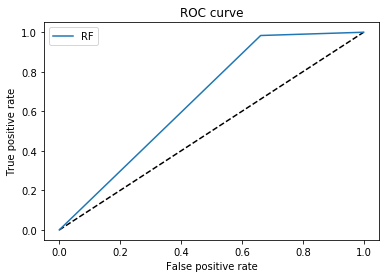

In [11]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report
from src.utils.utils import get_relative_project_dir, cprint


RANDOM_STATE = 777
#training data
X = Xx.side.values.reshape(-1,1)
#labels
y = Xx.bin.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy')

rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
